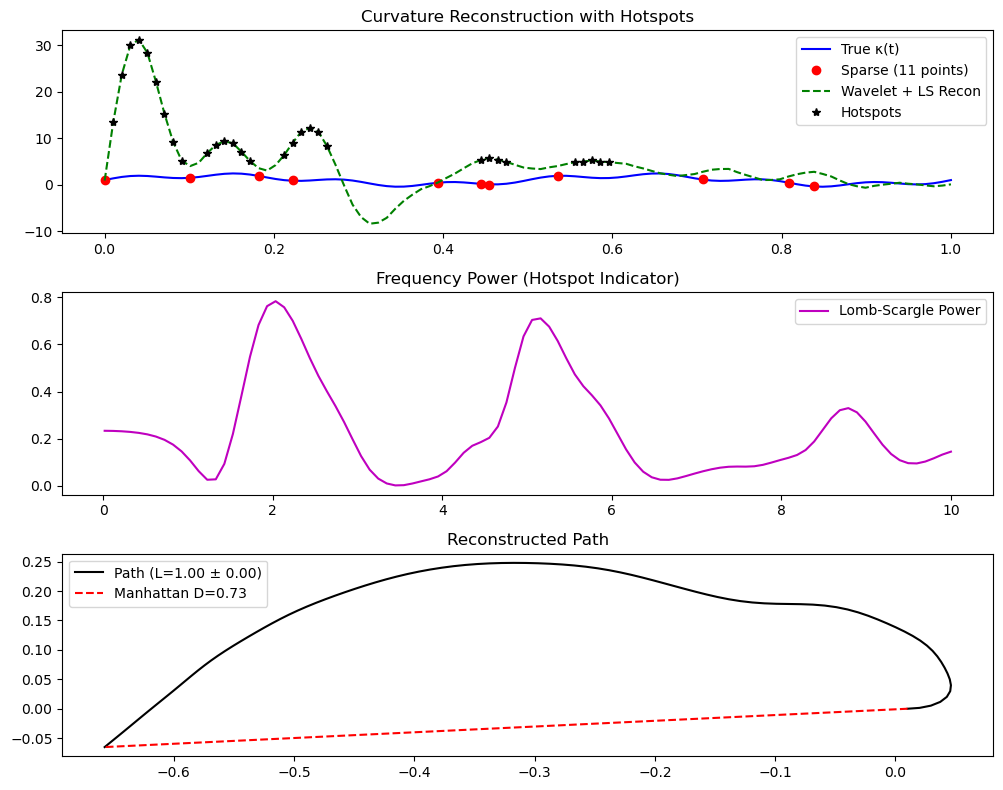

Estimated Length: 1.00 ± 0.00
Manhattan Distance: 0.73
Hotspots at t: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.12 0.13 0.14 0.15 0.16
 0.17 0.21 0.22 0.23 0.24 0.25 0.26 0.44 0.45 0.46 0.47 0.56 0.57 0.58
 0.59 0.6 ]


In [7]:
# Curvature
# Author: Neil Crago
# Date: 2025-09-07
# License: MIT

# Curvature Reconstruction and Path Length Estimation from Sparse Data
# This script simulates sparse curvature data, reconstructs it using wavelets and Lomb-Scargle
# periodogram, detects high-curvature hotspots, computes path length with z-bias, and
# incorporates Bayesian uncertainty estimation and QFT feedback for threshold adjustment.

import numpy as np
import pywt
from scipy.signal import lombscargle
from scipy.integrate import quad
import matplotlib.pyplot as plt

# Simulate sparse, unevenly spaced curvature data with varying lengths
np.random.seed(42)
t_full = np.linspace(0, 1, 100)  # Full grid for plotting
n_points = np.random.randint(5, 15)  # Vary number of points (5-14)
t_sparse = np.sort(np.random.choice(t_full, n_points, replace=False))  # Unevenly spaced
kappa_true = 1 + np.sin(4 * np.pi * t_full) + 0.5 * np.sin(16 * np.pi * t_full)  # Multi-scale
kappa_sparse = 1 + np.sin(4 * np.pi * t_sparse) + 0.5 * np.sin(16 * np.pi * t_sparse) + np.random.normal(0, 0.1, n_points)

# Lomb-Scargle periodogram to estimate κ frequencies
freqs = np.linspace(0.1, 20 * np.pi, 100)  # Frequency range
power = lombscargle(t_sparse, kappa_sparse - np.mean(kappa_sparse), freqs, normalize=True)
kappa_ls = np.zeros_like(t_full)
for i, t in enumerate(t_full):
    kappa_ls[i] = np.mean(kappa_sparse) + sum(np.sin(f * t) * np.sqrt(power[j]) for j, f in enumerate(freqs))

# Wavelet reconstruction for smoothness
wavelet = 'db2'
coeffs = pywt.wavedec(kappa_ls, wavelet, level=3)
threshold = 0.1  # Bayesian-inspired sparsity
coeffs_thresh = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
kappa_recon = pywt.waverec(coeffs_thresh, wavelet)[:len(t_full)]

# Hotspot detection: High-curvature regions
hotspot_threshold = np.percentile(kappa_recon, 70)  # Top 30% κ as hotspots
hotspots = kappa_recon > hotspot_threshold
hotspot_t = t_full[hotspots]

# Compute path length with z-bias
def compute_path_length(kappa, t, dz_dt=0.1):
    theta = np.cumsum(kappa) * (t[1] - t[0])  # Angle from κ
    x = np.cumsum(np.cos(theta)) * (t[1] - t[0])
    y = np.cumsum(np.sin(theta)) * (t[1] - t[0])
    integrand = lambda t_i: np.sqrt(np.cos(theta[int(t_i*99)])**2 + np.sin(theta[int(t_i*99)])**2 + dz_dt**2)
    L, _ = quad(integrand, 0, 1)
    return L, x, y

L, x, y = compute_path_length(kappa_recon, t_full)
D_manhattan = np.abs(x[-1] - x[0]) + np.abs(y[-1] - y[0])

# QFT feedback: Adjust threshold if L overshoots
if L > 2 * D_manhattan:
    threshold *= 0.55
    coeffs_thresh = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    kappa_recon = pywt.waverec(coeffs_thresh, wavelet)[:len(t_full)]
    L, x, y = compute_path_length(kappa_recon, t_full)

# Bayesian uncertainty: Sample wavelet coeffs
n_samples = 50
L_samples = []
for _ in range(n_samples):
    coeffs_sample = [c + np.random.laplace(0, 0.05, c.shape) for c in coeffs_thresh]
    kappa_sample = pywt.waverec(coeffs_sample, wavelet)[:len(t_full)]
    L_samp, _, _ = compute_path_length(kappa_sample, t_full)
    L_samples.append(L_samp)
L_mean, L_std = np.mean(L_samples), np.std(L_samples)

# Plot results
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
plt.plot(t_full, kappa_true, 'b-', label='True κ(t)')
plt.plot(t_sparse, kappa_sparse, 'ro', label=f'Sparse ({n_points} points)')
plt.plot(t_full, kappa_recon, 'g--', label='Wavelet + LS Recon')
plt.plot(t_full[hotspots], kappa_recon[hotspots], 'k*', label='Hotspots')
plt.legend()
plt.title('Curvature Reconstruction with Hotspots')
plt.subplot(3, 1, 2)
plt.plot(freqs / (2 * np.pi), power, 'm-', label='Lomb-Scargle Power')
plt.title('Frequency Power (Hotspot Indicator)')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(x, y, 'k-', label=f'Path (L={L:.2f} ± {L_std:.2f})')
plt.plot([x[0], x[-1]], [y[0], y[-1]], 'r--', label=f'Manhattan D={D_manhattan:.2f}')
plt.legend()
plt.title('Reconstructed Path')
plt.tight_layout()
plt.show()

print(f"Estimated Length: {L:.2f} ± {L_std:.2f}")
print(f"Manhattan Distance: {D_manhattan:.2f}")
print(f"Hotspots at t: {hotspot_t.round(2)}")